# Simulating Transmission Bottlenecks

One of the reviewers asked; 'assuming there is one index case on the boat, if the bottleneck is small and minor variants rare, how many transmission events would we have to observe for such an event to happen?' 

We can answer this with a 'simple' simulatation of transmission with multiple different sized bottlenecks for cases where you have more than one interval separating people in a transmission chain. The method I used to simulate transmission with a bottleneck was derived from [this paper](https://doi.org/10.1128/JVI.00171-17).

In [1]:
import numpy as np
import pandas as pd

from plotnine import *

from scipy.stats import binom, beta, poisson, expon, norm

I'll define a function to simulate transmission between a donor and recipient with multiple 'intervals' of transmission. I'm calling an interval an additional transmission event where the recipient viral population is re-defined as the donor population and subjected to another bottleneck. No new alleles are defined because we just care about the fate of the alleles that arose in the initial donor. 

Broadly, the idea for how this simulation works was taken from the methods of Ashley Sobel Leonard's [paper](https://doi.org/10.1128/JVI.00171-17). Basically, I start by establishing a set of donor hosts based on the number of `simulations` that I want to run. Each simulated donor has the number of variant alleles in their sequenced population drawn from a poisson distribution where $\lambda$ = the average number of mutations per crew member in our data. The 'true' frequency of each of those mutations is drawn from the exponential distribution where the mean of the distribution is the average allele frequency from in data. Read depth at each variant site is simulated with a normal distribution with a mean depth of 2000 and the number of variant reads is calculated with binomial draws where the number of trials is the read depth and the probability of success is the true allele frequency. Finally, we also simulate sequencing error with a binomial distribution and error rate of 0.01 to get the observed donor allele frequencies.

Transmission is simulated as a binomial draw from the donor population where the probability of success is the true allele frequency in the donor and the number of trials is the bottleneck. Stochasticity is modeled with the beta distribution.

In [2]:
def simulate_transmission(
    avg_subs_per_person,
    avg_allele_frequency,
    avg_read_depth,
    std_read_depth,
    bottleneck_size,
    sequencing_error_rate,
    variant_calling_threshold,
    n_simulations,
    n_intervals,
    verbose=False
):
    """Simulate pathogen transmissions at a given bottleneck.

    Parameters
    -----------
    avg_subs_per_person : float
        Average number of subclonal mutations in a person
    avg_allele_frequency : float
        Average frequency of a subclonal mutation
    avg_read_depth : int
        Average read depth in a sample
    std_read_depth : int
        Standard deviation of read depth
    sequencing_error_rate : float
        Illumina sequencing error rate
    bottleneck_size : int
        Size of the genetic bottleneck 
    variant_calling_threshold : float
        Minimum threshold to identify a variant 
    n_simulations : int
        The number of times to runs the transmission simulations
    n_intervals: int
        The number of serial intervals between donor and final contact

    Returns
    -------
    list
        List tuples containing the simulation number,
        contact number, donor allele frequencies, recipient allele frequencies, 
        and the variant index in a given simulation.

    """

    # Save the transmissions
    transmission_list = list()

    # Simulate `n_simulations` donors and the number of starting substitutions
    variants_in_donors = poisson.rvs(avg_subs_per_person, size=n_simulations)

    # For each donor, simulate starting variant frequencies and reads
    simulation = 0
    for n_variants in variants_in_donors:
        simulation += 1 # keep track of the simulation #
        if verbose: print(f"Starting Simulation #{simulation} with bottleneck: {bottleneck_size}\n")

        # There are no variants in this donor
        if n_variants == 0:
            if verbose: print("There were no variants in the donor.\n----------------------\n\n")
            transmission_list.append((simulation, 0, np.zeros(0), np.zeros(0), 0, np.zeros(0), np.zeros(0)))
            continue

        # Simulate read depth at each site with a normal distribution centered on our mean depth
        read_depth = norm.rvs(loc=avg_read_depth,
                              scale=std_read_depth,
                              size=n_variants).round().astype(int)

        # Simulate the true variant frequencies in the donor from the exonential distribution. 
        true_donor_frequencies = expon.rvs(scale=avg_allele_frequency,
                                           size=n_variants)

        # Only keep the indicies where the read depth is > 0 
        sites_to_keep = (read_depth > 0) 
        read_depth = read_depth[sites_to_keep]
        true_donor_frequencies = true_donor_frequencies[sites_to_keep]

        # There are no *detectable* variants in this donor
        if sum(sites_to_keep) == 0:
            transmission_list.append((simulation, n_variants, np.zeros(n_variants), np.zeros(n_variants), 0, np.zeros(n_variants), np.zeros(n_variants)))
            if verbose: print("There were no detectable variants in the donor.\n----------------------\n\n")
            continue

        # Simulate the true number of variant reads at each polymorphic site
        donor_variant_reads = binom.rvs(read_depth, true_donor_frequencies)

        # Factor in the sequencing error
        donor_false_positive = binom.rvs(read_depth - donor_variant_reads, sequencing_error_rate)
        donor_true_positive = binom.rvs(donor_variant_reads, 1 - sequencing_error_rate)

        # Calculate the observed variant frequencies
        observed_donor_frequencies = (donor_false_positive + donor_true_positive) / read_depth

#         if sum(variants_to_keep) == 0:
#             transmission_list.append((simulation, n_variants, np.zeros(n_variants), np.zeros(n_variants), 0, np.zeros(n_variants), np.zeros(n_variants)))
#             if verbose: print("There were no detectable variants in the donor.\n----------------------\n\n")
#             continue

        if verbose: print(f"Observed Frequencies in the Index: {observed_donor_frequencies}\n----------------------\n\n")   

        ## == Simulating the Recipients == ##

        if verbose: print("Simulating the Recipient:\n")

        # For each serial interval, set the frequency of the recipient to the donor and re-infect
        for interval in range(n_intervals): 

            if verbose: print(f"Serial Interval {interval + 1} of {n_intervals}:\n")

            # The true number of founding *variant* virions based on the bottleneck and donor freq
            k_founding_variant_virions = binom.rvs(bottleneck_size, true_donor_frequencies)
            if isinstance(k_founding_variant_virions, int):
                n_founding_variants = 1
                k_founding_variant_virions = np.array([k_founding_variant_virions])
            else:
                n_founding_variants = len(k_founding_variant_virions)

            if verbose: print(f"There are {n_founding_variants} founding variants")

            # Use the beta distribution to simulate stochasticity in the recipient host
            try:
                true_recipient_frequency = beta.rvs(k_founding_variant_virions,
                                                    (bottleneck_size-k_founding_variant_virions))
                if isinstance(true_recipient_frequency, float): 
                    true_recipient_frequency = np.array([true_recipient_frequency])
            except:
                # If there are no founding viruses or the variants fixes:
                true_recipient_frequency = np.zeros(n_founding_variants)
                for i in range(n_founding_variants):
                    k_variants = k_founding_variant_virions[i]
                    # If a variant fixes:
                    if k_variants == bottleneck_size:
                        true_recipient_frequency[i] = 1.0
                    # If it's more than 0:
                    elif k_variants != 0:
                        true_recipient_frequency[i] = beta.rvs(k_variants,
                                                              (bottleneck_size-k_variants))
                    # Otherwise, it's true frequenecy is 0
                    else:
                        true_recipient_frequency[i] = 0.0

            # Determine the true variant read count
            recipient_variant_reads = binom.rvs(read_depth, true_recipient_frequency)

            # Factor in the sequencing error
            recipient_false_positive = binom.rvs(read_depth - recipient_variant_reads, sequencing_error_rate)
            recipient_true_positive = binom.rvs(recipient_variant_reads, 1 - sequencing_error_rate)

            # Calculate the observed variant frequencies
            observed_recipient_frequencies = (recipient_false_positive + recipient_true_positive) / read_depth

            # Anything less than the threshold is automatically 0
            observed_recipient_frequencies[observed_recipient_frequencies < variant_calling_threshold] = 0.0

            # Save the state of the transmissioin
            transmission_list.append((simulation,
                                      n_variants,
                                      true_donor_frequencies,
                                      observed_donor_frequencies,
                                      interval + 1,
                                      true_recipient_frequency,
                                      observed_recipient_frequencies))

            # Reset as the donor and remove the alleles that are below the error threshold?
            true_donor_frequencies = true_recipient_frequency

            if verbose: print(f"We observe them at: {observed_recipient_frequencies} frequencies\n---------------\n\n")

    # Convert the transmission list into a dataframe:
    df_list = list()
    for event in transmission_list:
        df = pd.DataFrame(zip(event[2], event[3], event[5], event[6]),
                          columns = ["true_donor_af",
                                     "obsv_donor_af",
                                     "true_recipient_af",
                                     "obsv_recipient_af",])
        df['simulation'] = event[0]
        df['interval'] = event[4]
        df_list.append(df)

    transmission_df = pd.concat(df_list)
    

    return transmission_df


### Parameters for Transmission 

All of these parameters are derived from our data except for the standard devation of read depth. 

In [3]:
## === Parameters === ##

# Average substitutions per person
subs_per_person = 2.53

# Average read depth
read_depth = 2000

# Standard Deviation 
read_depth_dev = 100

# The average variant frequency 
allele_frequency = 0.073

# Rate of sequencing error
error_rate = 0.01

# Variant Calling Minimum (below we think it could be an error)
threshold = 0.02

Simulating 100 times for each bottleneck between 1 and 10,000 founding virions, how many intervals of transmission does it take to fix a minor variant? 

In [4]:
bottleneck_sim_list = list()

for bottleneck in np.geomspace(1, 10_000, 25).round().astype(int):
    transmission_df = simulate_transmission(
        avg_subs_per_person=subs_per_person,
        avg_allele_frequency=allele_frequency,
        avg_read_depth=read_depth,
        std_read_depth=read_depth_dev,
        sequencing_error_rate=error_rate,
        variant_calling_threshold=threshold,
        bottleneck_size=bottleneck,
        n_simulations=100,
        n_intervals=20,
        verbose=False
    )

    transmission_df = transmission_df.reset_index().rename(columns={'index': 'variant'})
    transmission_df['bottleneck'] = bottleneck
    bottleneck_sim_list.append(transmission_df)
    
bottleneck_sim_df = pd.concat(bottleneck_sim_list)

A variant reaches fixation in the infection interval where the variant is not fixed in the donor but is fixed in the recipient. I'll determine the mean interval where this happens at each bottleneck value. 

In [5]:
fixed_dict = dict()

for bottleneck in bottleneck_sim_df.bottleneck.unique():
    
    fixed_intervals = (bottleneck_sim_df
     .query(f"bottleneck == {bottleneck}")
     .query("true_donor_af != 1 and true_recipient_af == 1")
    ).interval.mean()
    
    fixed_dict[bottleneck] = fixed_intervals

fixed_interval_df = pd.DataFrame(fixed_dict.items(), columns=['Bottleneck', 'Mean_Intervals']).fillna(0)

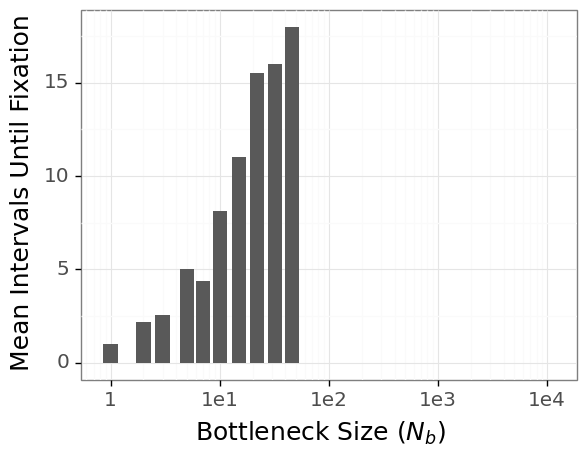

<ggplot: (8727322795737)>

In [6]:

mean_interval_plot = (
ggplot(data = fixed_interval_df, mapping = aes(x = "Bottleneck", y = "Mean_Intervals"))
    + geom_bar(stat="identity")
    + xlab("Bottleneck Size ($N_b$)")
    + ylab("Mean Intervals Until Fixation")
    + scale_x_log10()
    + theme_bw(18)
)
mean_interval_plot

As expected, the tighter the bottleneck, the fewer intervals are need to fix the variant. The wider the bottleneck, the less likely a variant is to fix through transmission alone. 

In [7]:
bottleneck_sim_list = list()

for bottleneck in np.linspace(1, 15, 15).round().astype(int):
    transmission_df = simulate_transmission(
        avg_subs_per_person=subs_per_person,
        avg_allele_frequency=allele_frequency,
        avg_read_depth=read_depth,
        std_read_depth=read_depth_dev,
        sequencing_error_rate=error_rate,
        variant_calling_threshold=threshold,
        bottleneck_size=bottleneck,
        n_simulations=1000,
        n_intervals=3,
        verbose=False
    )

    transmission_df = transmission_df.reset_index().rename(columns={'index': 'variant'})
    transmission_df['bottleneck'] = bottleneck
    bottleneck_sim_list.append(transmission_df)
    
bottleneck_sim_df = pd.concat(bottleneck_sim_list)

In [8]:
# Calculte how many transmission result in a fixation event
# When the true allele frequency in the recipient is 1 but the donor wasn't, that's fixed.
percent_simulations_fixed_df = (
bottleneck_sim_df
     .query("true_donor_af != 1 and true_recipient_af == 1")
     .groupby(['bottleneck'])
     .agg({'simulation': 'count'})
     .reset_index()
     .assign(percent_fixed = lambda x: (x.simulation / bottleneck_sim_df.simulation.max()) * 100)
)

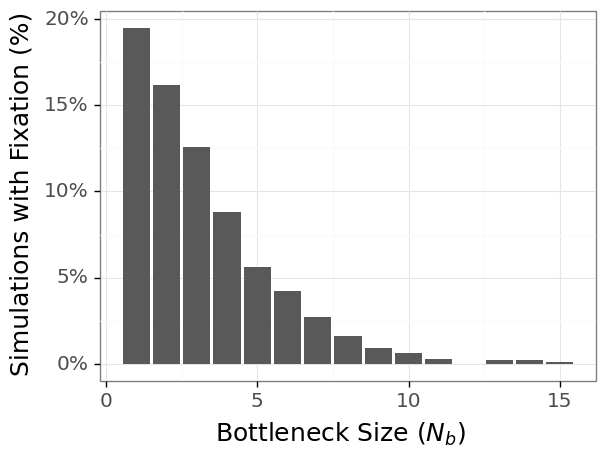

<ggplot: (8727323364133)>

In [9]:
percent_fixed_plot = (
ggplot(data = percent_simulations_fixed_df, mapping = aes(x = "bottleneck", y = "percent_fixed"))
    + geom_bar(stat="identity")
    + xlab("Bottleneck Size ($N_b$)")
    + ylab("Simulations with Fixation (%)")
    + scale_y_continuous(labels=lambda l: ["%d%%" % (v) for v in l])
    + theme_bw(18)
)
percent_fixed_plot

In [12]:
percent_fixed_plot.save(filename = '../../results/figures/percent-fixed-in-3-intervals.png', height=5, width=7, units = 'in', dpi=300)

/home/whannon/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7 x 5 in image.
/home/whannon/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../results/figures/percent-fixed-in-3-intervals.png


In [11]:
percent_simulations_fixed_df.assign(power_calculation = lambda x: round(1/(x.percent_fixed/100)))

,bottleneck,simulation,percent_fixed,power_calculation
0,1,195,19.5,5.0
1,2,162,16.2,6.0
2,3,126,12.6,8.0
3,4,88,8.8,11.0
4,5,56,5.6,18.0
5,6,42,4.2,24.0
6,7,27,2.7,37.0
7,8,16,1.6,62.0
8,9,9,0.9,111.0
9,10,6,0.6,167.0
